In [4]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog as fd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns

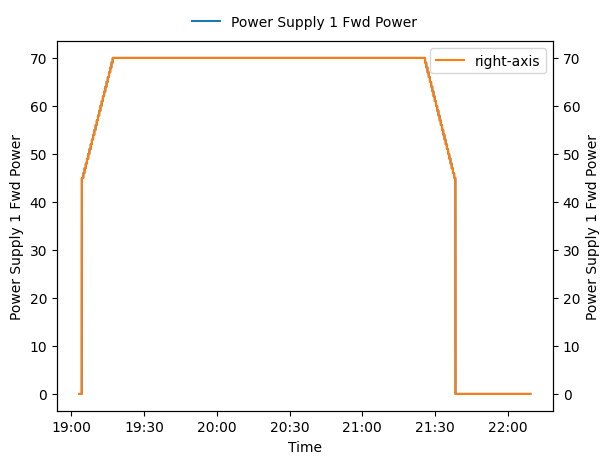

In [35]:
path = r'C:\Users\lopezb41\OneDrive - imec\Desktop\test\ITO and Pt 2023.02.28-19.03.17.csv'
col = ['Power Supply 1 Fwd Power', 'Power Supply 1 DC Bias', 'PC Capman Pressure', 'PC MFC 1 Flow', 'PC MFC 2 Flow', 'PC MFC 3 Flow', 'Power Supply 5 Voltage', 'Power Supply 5 Current', 'Substrate Heater Temperature'] #MFC1 = Ar, MFC2 = N2, MFC3 = O2
df = pd.read_csv(path, skiprows=3)
format_string = '%b-%d-%Y %I:%M:%S.%f %p' # Fix datetime stamp
df['Time'] = [datetime.strptime(i, format_string) for i in df['Time Stamp']]

fig, ax = plt.subplots()
ax2 = ax2 = ax.twinx()
sns.lineplot(data = df, x ='Time', y = col[0], ax = ax, label = col[0]) 
sns.lineplot(data = df, x ='Time', y = col[0], ax = ax2, color  = 'tab:orange', label = 'right-axis') 
sns.move_legend(ax, "lower center", ncol = 2, bbox_to_anchor=(0.5, 1), frameon = False)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) # X - axis tick format for date